In [1]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
# old code
from nnperm.perm import Permutations, PermutationSpec, perm_compose, perm_inverse
from nnperm.utils import get_open_lth_model

model_name_to_dir = {
    "cifar_vgg_16_8": "lottery_3d9c91d3d4133cfcdcb2006da1507cbb",
    "cifar_vgg_16_16": "lottery_2915b34d8b29a209ffee2288466cf5f6",
    "cifar_vgg_16_32": "lottery_c855d7c25ffef997a89799dc08931e82",
    "cifar_vgg_16_128": "lottery_8d561a7b273e4d6b2705ba6d627a69bd",
    "cifar_vgg_16_256": "lottery_a309ac4ab15380928661e70ca8b054a1",
}
# target_sizes = get_model_perm_size("lottery_2915b34d8b29a209ffee2288466cf5f6")
model = get_open_lth_model(Path(f"../refactor-outputs/ckpts/lottery_3d9c91d3d4133cfcdcb2006da1507cbb/dummy_ckpt.pth"), "cpu")
print(list(model.state_dict().keys()))

def get_model_perm_size(model_name):
    model = get_open_lth_model(Path(f"../refactor-outputs/ckpts/{model_name}/dummy_ckpt.pth"), "cpu")
    perm_spec = PermutationSpec.from_sequential_model(model.state_dict())
    return perm_spec.get_sizes(model.state_dict())

def classify_perm_fractions(perms_a, perms_b, align_sizes):
    for k in perms_a.keys():
        max_size = max(len(perms_a[k]), len(perms_b[k]))
        n_align = align_sizes[k]
        perm_a = perms_a[k][:n_align]
        perm_b = perms_b[k][:n_align]
        set_a = np.zeros(max_size, dtype=bool)
        set_a[perm_a] = True
        set_b = np.zeros(max_size, dtype=bool)
        set_b[perm_b] = True
        identical = (perm_a == perm_b)
        repermuted = set_a * set_b
        repermuted_a = np.logical_and(repermuted[perm_a], perm_a != perm_b)
        repermuted_b = np.logical_and(repermuted[perm_b], perm_a != perm_b)
        assert np.all(np.sum(repermuted_a) == np.sum(repermuted_b))
        unaligned = np.logical_xor(set_a, set_b)
        unaligned_a = unaligned[perm_a]
        unaligned_b = unaligned[perm_b]
        assert np.all(np.sum(unaligned_a) == np.sum(unaligned_b))
        assert np.all(identical + repermuted_a + unaligned_a == 1)
        assert np.all(identical + repermuted_b + unaligned_b == 1)
        yield k, n_align, identical, repermuted_a, repermuted_b, unaligned_a, unaligned_b

stats_dir = Path("../refactor-outputs/fix-embed-lottery_c855d7c25ffef997a89799dc08931e82/")
for file in stats_dir.glob("*linear.pt"):
    name = file.stem
    for k, v in model_name_to_dir.items():
        if v in file.stem:
            name = k
            key = v
    direct_perm_stats_dict = torch.load(f"../refactor-outputs/kernel-test/scratch/open_lth_data/{key}_1_2_pretrain_ep160_linear.pt")
    print(name, file.stem)
    sizes = get_model_perm_size(key)
    stats_dict = torch.load(file)
    perm_a = Permutations(stats_dict["perm_a"])
    perm_b = Permutations(stats_dict["perm_b"])
    direct_perm = Permutations(direct_perm_stats_dict['perm'])
    target_sizes = stats_dict["target_sizes"]
    for k, n, identical, r_a, r_b, u_a, u_b in classify_perm_fractions(perm_a, perm_b, sizes):
        print(k, n, np.sum(identical) / n, np.sum(r_a) / n, np.sum(u_a) / n)
    for k, n, identical, r_a, r_b, u_a, u_b in classify_perm_fractions(direct_perm, perm_a.inverse().compose(perm_b), sizes):
        print(k, n, np.sum(identical) / n, np.sum(r_a) / n, np.sum(u_a) / n)


['layers.0.conv.weight', 'layers.0.conv.bias', 'layers.0.bn.layernorm.weight', 'layers.0.bn.layernorm.bias', 'layers.1.conv.weight', 'layers.1.conv.bias', 'layers.1.bn.layernorm.weight', 'layers.1.bn.layernorm.bias', 'layers.3.conv.weight', 'layers.3.conv.bias', 'layers.3.bn.layernorm.weight', 'layers.3.bn.layernorm.bias', 'layers.4.conv.weight', 'layers.4.conv.bias', 'layers.4.bn.layernorm.weight', 'layers.4.bn.layernorm.bias', 'layers.6.conv.weight', 'layers.6.conv.bias', 'layers.6.bn.layernorm.weight', 'layers.6.bn.layernorm.bias', 'layers.7.conv.weight', 'layers.7.conv.bias', 'layers.7.bn.layernorm.weight', 'layers.7.bn.layernorm.bias', 'layers.8.conv.weight', 'layers.8.conv.bias', 'layers.8.bn.layernorm.weight', 'layers.8.bn.layernorm.bias', 'layers.10.conv.weight', 'layers.10.conv.bias', 'layers.10.bn.layernorm.weight', 'layers.10.bn.layernorm.bias', 'layers.11.conv.weight', 'layers.11.conv.bias', 'layers.11.bn.layernorm.weight', 'layers.11.bn.layernorm.bias', 'layers.12.conv.wei

<AxesSubplot:xlabel='wide.width.scale', ylabel='acc_barrier'>

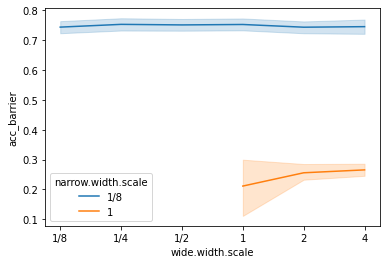

In [19]:
hash_to_model = {
    "fc3385ddd61e71e3234844f1584212ab": ("vgg_16_8", "svhn"),
    "0623cbc53a96baa5d56e0c04aa910cf3": ("vgg_16_16", "svhn"),
    "518ee26e9ef0aa8a2e6c0a5423cf44f2": ("vgg_16_32", "svhn"),
    "89d67a52bb2e16b7aa93e84bf7c85302": ("vgg_16_64", "svhn"),
    "69fd4b9f1c515d4ee872a935ef48b0d2": ("vgg_16_128", "svhn"),
    "ec5595f1318dc58e91af299a37eb6071": ("vgg_16_256", "svhn"),
    "688106d9fc0da7db4cebd981434750ee": ("vgg_16_8", "cifar10"),
    "812938fad9d6a452c60de777ad8b9ba2": ("vgg_16_16", "cifar10"),
    "e1ee2ce029f3688fdba8d16bcd72101b": ("vgg_16_32", "cifar10"),
    "b49ffe5e5a5c5bc82fd39df5f148ee0d": ("vgg_16_64", "cifar10"),
    "3ed390b5f8f0b92d658244d053e538e7": ("vgg_16_128", "cifar10"),
    "23d95a4841f5114daaeb195dcd3bce62": ("vgg_16_256", "cifar10"),
    "a33c07402a0c44b5ce98c8f42cc7de20": ("vgg_16_8", "cifar100"),
    "f474c902c60155e9ff25d9d4a710a869": ("vgg_16_16", "cifar100"),
    "4293247e3b0d0d76098cf66d61521885": ("vgg_16_32", "cifar100"),
    "5e2581215475976433f5c3aee127f570": ("vgg_16_64", "cifar100"),
    "5d365e1864a0effd4a92034b20b3cc5f": ("vgg_16_128", "cifar100"),
    "6020cd42026a268e84a95f95b44a931f": ("vgg_16_256", "cifar100"),
}
scale = {
    8: "1/8",
    16: "1/4",
    32: "1/2",
    64: "1",
    128: "2",
    256: "4",
}
runs = pd.read_csv("../refactor-outputs/narrow-wide/barriers.csv")
runs["wide"] = runs["path"].apply(lambda x: x.split("lottery_")[1].split("/")[0])
runs["wide.hash"] = runs["wide"].apply(lambda x: x.split("-")[0])
runs["wide.width"] = runs["wide.hash"].apply(lambda x: int(hash_to_model[x][0].split("_")[2]))
runs["wide.width.scale"] = runs["wide.width"].apply(lambda x: scale[x])
runs["wide.dataset"] = runs["wide.hash"].apply(lambda x: hash_to_model[x][1])
runs["narrow.hash"] = runs["path"].apply(lambda x: x.split("lottery_")[2].split("/")[0])
runs["narrow.width"] = runs["narrow.hash"].apply(lambda x: int(hash_to_model[x][0].split("_")[2]))
runs["narrow.width.scale"] = runs["narrow.width"].apply(lambda x: scale[x])
runs["narrow.dataset"] = runs["wide.hash"].apply(lambda x: hash_to_model[x][1])
runs["acc_barrier"] = runs["acc_barrier"] * -1
runs = runs.sort_values("wide.width")
# hparams = pd.read_csv("../refactor-outputs/exp-hparams.csv")
# hparams["Path.hash"] = hparams["Path"].apply(lambda x: Path(x).name.split("_")[1])
# train_dataset = hparams[["Path", "Path.hash", "dataset_hparams.dataset_name", "model_hparams.model_name"]]
# runs = train_dataset.merge(runs, left_on="Path.hash", right_on="hash", suffixes=("", ""))
sns.lineplot(data=runs, x="wide.width.scale", y="acc_barrier", hue="narrow.width.scale")